# Image Processing SS 16 - Assignment - 02

### Deadline is 4.5.2016 at 16:00 o'clock

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.


# Exercise 1 - 10 Points

Implement affine transformation with [bicubic interpolation](https://en.wikipedia.org/wiki/Bicubic_interpolation).

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

The [skimage](http://scikit-image.org/) library comes with multiple useful test images.  Let's start with an image of an astronaut. 

In [3]:
from skimage.data import astronaut
from skimage.color import rgb2gray

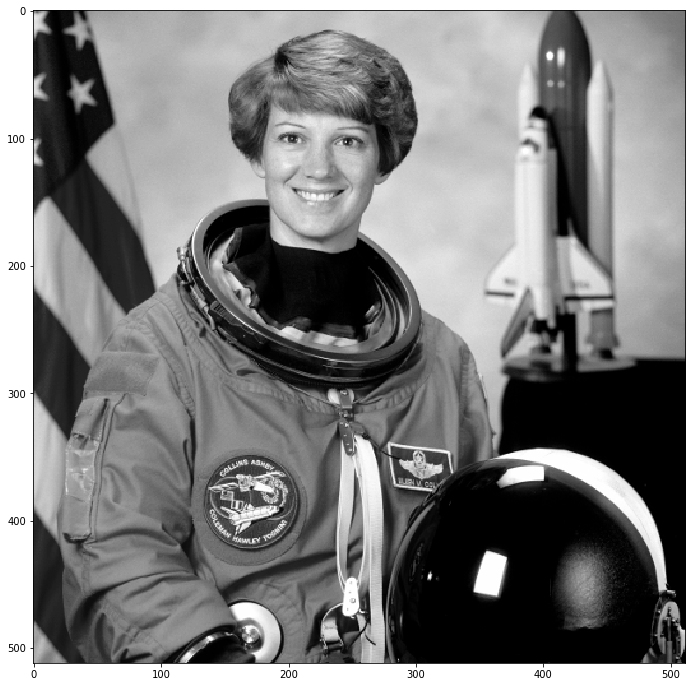

In [4]:
# We use a gray image. All the algorithms should work with color images too.
img = rgb2gray(astronaut() / 255.)
plt.imshow(img, cmap='gray')
plt.show()

In [5]:
def derive_y(image):
    """Computes the derivative of the image w.r.t the y coordinate"""
    derived_image = np.zeros_like(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if y + 1 < image.shape[1] and y - 1 > 0:
                derived_image[x,y] = image[x, y - 1] - image[x, y + 1]
    return derived_image

def derive_x(image):
    """Computes the derivative of the image w.r.t the x coordinate"""
    derived_image = np.zeros_like(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if x + 1 < image.shape[1] and x - 1 > 0:
                derived_image[x,y] = image[x - 1, y] - image[x + 1, y]
    return derived_image

In [6]:
dx_img = derive_x(img)
dy_img = derive_y(img)

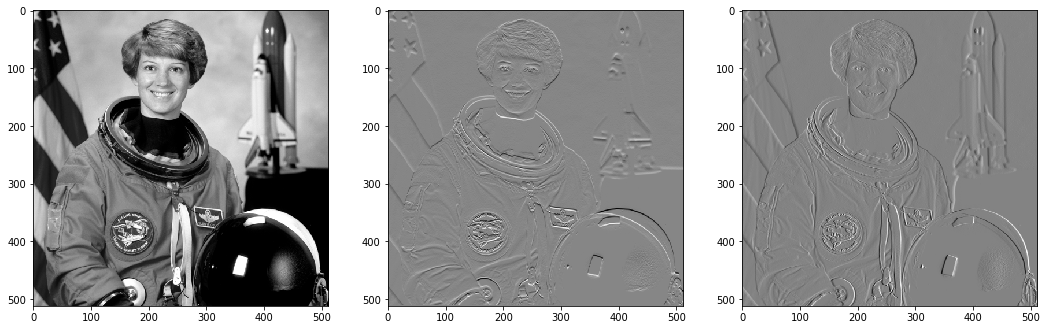

In [7]:
plt.figure(figsize=(18, 12))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.imshow(dx_img, cmap='gray')
plt.subplot(133)
plt.imshow(dy_img, cmap='gray')
plt.show()

In [8]:
# The derivatives are no longer in the range [0,1].
print("min: {}, max: {}".format(dx_img.min(), dx_img.max()))

min: -0.9896796078431372, max: 0.8965913725490197


In [9]:
indicies = np.indices(img.shape).reshape(2, -1)
indicies.shape

(2, 262144)

In [10]:
# pick some random index

In [11]:
indicies[:, 123456]

array([241,  64])

In [12]:
indicies_hg = np.concatenate([
        indicies, np.ones((1, indicies.shape[1]))], axis=0)
indicies_hg.shape

(3, 262144)

In [13]:
indicies_hg[:, 123456]

array([241.,  64.,   1.])

In [14]:
T_scale = np.array([
    [0.75, 0, 0],
    [0, 0.75, 0],
    [0, 0, 1],
])
# np.dot(T_affine, indicies_hg).shape, for python < 3.5
(T_scale @ indicies_hg).shape

(3, 262144)

In [22]:
T_affine = np.array([
    [1, 0.3, 0],
    [0, 1, 0],
    [0, 0, 1],
])

In [16]:
# you can use this function to invert the matricies
np.linalg.inv(T_scale)

array([[1.33333333, 0.        , 0.        ],
       [0.        , 1.33333333, 0.        ],
       [0.        , 0.        , 1.        ]])

In [17]:
def affine_transformation(img, matrix):
    indicies = np.indices(img.shape).reshape(2, -1)
    indicies_hg = matrix @ np.concatenate([indicies, np.ones((1, indicies.shape[1]))], axis=0)
    
    res_img = np.zeros((int(np.ceil(np.max(indicies_hg[0,:]))), int(np.ceil(np.max(indicies_hg[1,:])))))
    indicies_res = np.indices(res_img.shape).reshape(2, -1)
    indicies_res_hg = np.concatenate([indicies_res, np.ones((1, indicies_res.shape[1]))], axis=0)
    indicies_interpolation = np.linalg.inv(matrix) @ indicies_res_hg
    
    return bicubic_interpolation(img, indicies_interpolation, matrix, res_img)

In [18]:
def bicubic_interpolation(img, indicies, matrix, result):
    dx_img = derive_x(img)
    dy_img = derive_y(img)
    dxy_img = derive_x(dy_img)
    inv_matrix = np.array([
        [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-3,  3,  0,  0, -2, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, -2,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -3,  3,  0,  0, -2, -1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  2, -2,  0,  0,  1,  1,  0,  0],
        [-3,  0,  3,  0,  0,  0,  0,  0, -2,  0, -1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, -3,  0,  3,  0,  0,  0,  0,  0, -2,  0, -1,  0],
        [ 9, -9, -9,  9,  6,  3, -6, -3,  6, -6,  3, -3,  4,  2,  2,  1],
        [-6,  6,  6, -6, -3, -3,  3,  3, -4,  4, -2,  2, -2, -2, -1, -1],
        [ 2,  0, -2,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  2,  0, -2,  0,  0,  0,  0,  0,  1,  0,  1,  0],
        [-6,  6,  6, -6, -4, -2,  4,  2, -3,  3, -3,  3, -2, -1, -2, -1],
        [ 4, -4, -4,  4,  2,  2, -2, -2,  2, -2,  2, -2,  1,  1,  1,  1]
    ])

    x_size = img.shape[0]
    y_size = img.shape[1]
    
    for i in range(indicies.shape[-1]):
        point = indicies[:, i]
        x_val_floor = int(np.floor(point[0]))
        x_val_ceil = int(np.ceil(point[0]))
        y_val_floor = int(np.floor(point[1]))
        y_val_ceil = int(np.ceil(point[1]))

        if 0 < x_val_floor < x_size and 0 < x_val_ceil < x_size and 0 < y_val_floor < y_size and 0 < y_val_ceil < y_size:
            func_values = np.array([
                img[x_val_floor][y_val_floor], img[x_val_ceil][y_val_floor], img[x_val_floor][y_val_ceil], img[x_val_ceil][y_val_ceil],
                dx_img[x_val_floor][y_val_floor], dx_img[x_val_ceil][y_val_floor], dx_img[x_val_floor][y_val_ceil], dx_img[x_val_ceil][y_val_ceil],
                dy_img[x_val_floor][y_val_floor], dy_img[x_val_ceil][y_val_floor], dy_img[x_val_floor][y_val_ceil], dy_img[x_val_ceil][y_val_ceil],
                dxy_img[x_val_floor][y_val_floor], dxy_img[x_val_ceil][y_val_floor], dxy_img[x_val_floor][y_val_ceil], dxy_img[x_val_ceil][y_val_ceil]
            ])
            alpha = inv_matrix @ func_values
            res_point = matrix @ point
            result[int(np.rint(res_point[0]))][int(np.rint(res_point[1]))] = calc_value(point[0] - x_val_floor, point[1] - y_val_floor, alpha)

    return result

def calc_value(x, y, alpha):
    x_pow2 = x ** 2
    x_pow3 = x ** 3
    y_pow2 = y ** 2
    y_pow3 = y ** 3
    
    return alpha[0] + alpha[4] * y +  alpha[8] * y_pow2 + alpha[12] * y_pow3\
        + (alpha[1] + alpha[5] * y +  alpha[9] * y_pow2 + alpha[13] * y_pow3) * x\
        + (alpha[2] + alpha[6] * y + alpha[10] * y_pow2 + alpha[14] * y_pow3) * x_pow2\
        + (alpha[3] + alpha[7] * y + alpha[11] * y_pow2 + alpha[15] * y_pow3) * x_pow3\

In [23]:
img_scale = affine_transformation(img, T_scale)
img_affine = affine_transformation(img, T_affine)

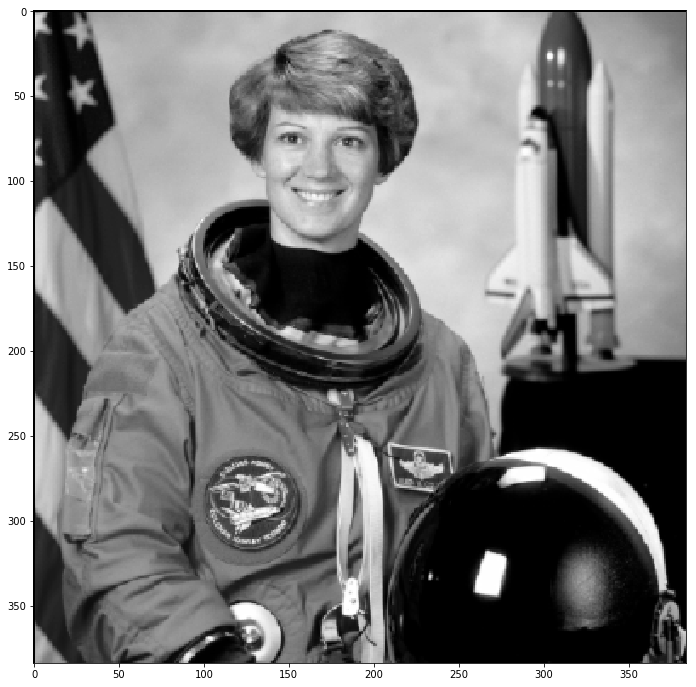

In [24]:
plt.imshow(img_scale, cmap='gray')
plt.show()

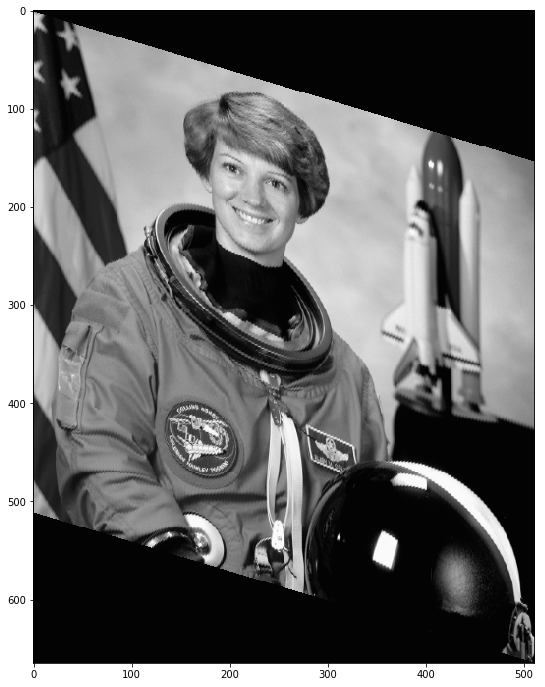

In [25]:
plt.imshow(img_affine, cmap='gray')
plt.show()